# VRP con Algoritmo Genético
Notebook generado automáticamente con el código del usuario, dividido en secciones claras.

## 1. Importación de librerías

In [1]:
import random
import math
import matplotlib.pyplot as plt

## 2. Datos del problema

In [2]:
depot = [20, 120]
clientes = [
    [35, 115],
    [50, 140],
    [70, 100],
    [40, 80],
    [25, 60]
]

pesos = [1.2, 3.8, 7.5, 0.9, 15.4, 12.1, 4.3, 19.7, 8.6, 2.5]

pedidos = [
    [(3, 2), (1, 3)],
    [(2, 6)],
    [(7, 4), (5, 2)],
    [(3, 8)],
    [(6, 5), (9, 2)]
]

## 3. Cálculo de demandas

In [3]:
demandas = []
for pedido in pedidos:
    total = 0
    for item, cant in pedido:
        total += pesos[item - 1] * cant
    demandas.append(total)

capacidad = 80

print('Demandas calculadas:', demandas)

Demandas calculadas: [18.6, 22.799999999999997, 48.0, 60.0, 77.7]


## 4. Filtrar clientes según capacidad

In [4]:
clientes_validos = []
demandas_validas = []
clientes_invalidos = []
demandas_invalidas = []

for i in range(len(clientes)):
    if demandas[i] <= capacidad:
        clientes_validos.append(clientes[i])
        demandas_validas.append(demandas[i])
    else:
        clientes_invalidos.append(clientes[i])
        demandas_invalidas.append(demandas[i])

print('Clientes válidos:', clientes_validos)
print('Demandas válidas:', demandas_validas)
print('Clientes inválidos:', clientes_invalidos)
print('Demandas inválidas:', demandas_invalidas)

Clientes válidos: [[35, 115], [50, 140], [70, 100], [40, 80], [25, 60]]
Demandas válidas: [18.6, 22.799999999999997, 48.0, 60.0, 77.7]
Clientes inválidos: []
Demandas inválidas: []


## 5. Funciones auxiliares

In [5]:
def distancia(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def dividir_en_rutas(ruta):
    rutas = []
    carga = 0
    actual = []
    for c in ruta:
        if carga + demandas_validas[c] <= capacidad:
            actual.append(c)
            carga += demandas_validas[c]
        else:
            rutas.append(actual)
            actual = [c]
            carga = demandas_validas[c]
    if actual:
        rutas.append(actual)
    return rutas

def distancia_total(ruta):
    rutas = dividir_en_rutas(ruta)
    total = 0
    for r in rutas:
        pos = depot
        for c in r:
            total += distancia(pos, clientes_validos[c])
            pos = clientes_validos[c]
        total += distancia(pos, depot)
    return total

def fitness(ruta):
    return distancia_total(ruta)

## 6. Operadores genéticos

In [6]:
def crear_poblacion(n, n_clientes):
    poblacion = []
    base = list(range(n_clientes))
    for _ in range(n):
        r = base[:]
        random.shuffle(r)
        poblacion.append(r)
    return poblacion

def seleccion(poblacion, fitnesses):
    i1, i2 = random.sample(range(len(poblacion)), 2)
    if fitnesses[i1] < fitnesses[i2]:
        return poblacion[i1][:]
    return poblacion[i2][:]

def cruce(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    hijo = [-1] * len(p1)
    hijo[a:b] = p1[a:b]
    pos = b
    for x in p2:
        if x not in hijo:
            if pos >= len(p1):
                pos = 0
            hijo[pos] = x
            pos += 1
    return hijo

def mutacion(ruta, prob=0.1):
    if random.random() < prob:
        i, j = random.sample(range(len(ruta)), 2)
        ruta[i], ruta[j] = ruta[j], ruta[i]

## 7. Algoritmo Genético

In [7]:
def algoritmo_genetico(n_generaciones=200, tam_pob=50):
    poblacion = crear_poblacion(tam_pob, len(clientes_validos))
    fitnesses = [fitness(r) for r in poblacion]

    for _ in range(n_generaciones):
        nueva = []
        for _ in range(tam_pob):
            p1 = seleccion(poblacion, fitnesses)
            p2 = seleccion(poblacion, fitnesses)
            hijo = cruce(p1, p2)
            mutacion(hijo, 0.1)
            nueva.append(hijo)
        poblacion = nueva
        fitnesses = [fitness(r) for r in poblacion]

    mejor = min(range(tam_pob), key=lambda i: fitnesses[i])
    return poblacion[mejor], fitnesses[mejor]

## 8. Ejecutar optimización

In [8]:
mejor_ruta, mejor_valor = algoritmo_genetico()

print('Orden de visita:', mejor_ruta)
print('Distancia total:', round(mejor_valor, 2))

Orden de visita: [1, 2, 4, 3, 0]
Distancia total: 350.93


## 9. Mostrar viajes resultantes

In [9]:
rutas = dividir_en_rutas(mejor_ruta)

for i, r in enumerate(rutas):
    carga = sum(demandas_validas[c] for c in r)
    print(f'Viaje {i+1}: {r}  (Carga {round(carga,1)} kg)')

Viaje 1: [1, 2]  (Carga 70.8 kg)
Viaje 2: [4]  (Carga 77.7 kg)
Viaje 3: [3, 0]  (Carga 78.6 kg)


## 10. Plot de rutas

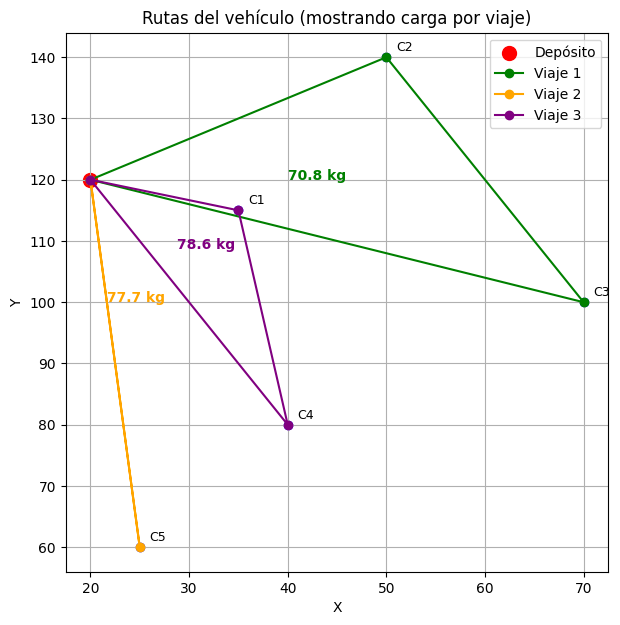

In [10]:
def plot_rutas(rutas):
    plt.figure(figsize=(7, 7))

    for i, (x, y) in enumerate(clientes_validos):
        plt.scatter(x, y, c='blue')
        plt.text(x+1, y+1, f'C{i+1}', fontsize=9)

    plt.scatter(depot[0], depot[1], c='red', s=100, label='Depósito')

    colores = ['green', 'orange', 'purple', 'cyan', 'brown']

    for i, r in enumerate(rutas):
        puntos = [depot] + [clientes_validos[c] for c in r] + [depot]
        xs = [p[0] for p in puntos]
        ys = [p[1] for p in puntos]
        plt.plot(xs, ys, '-o', color=colores[i % len(colores)], label=f'Viaje {i+1}')

        carga = sum(demandas_validas[c] for c in r)
        x_text = sum(xs) / len(xs)
        y_text = sum(ys) / len(ys)
        plt.text(x_text, y_text, f'{round(carga,1)} kg', fontsize=10, color=colores[i % len(colores)], fontweight='bold')

    for (x, y) in clientes_invalidos:
        plt.scatter(x, y, c='gray', marker='x')
        plt.text(x+1, y+1, 'Inválido', fontsize=9, color='magenta')

    plt.title('Rutas del vehículo (mostrando carga por viaje)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rutas(rutas)